<a href="https://www.kaggle.com/code/sarahbenabdallah/tp3-rnn?scriptVersionId=94865845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/original-embeddings/GoogleNews-vectors-negative300(first500000).txt
/kaggle/input/original-embeddings/glove.6B.300d.txt
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


**Importation des bibliothèques**

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


**Importation du dataset**
 
Importer IMDB dataset en utilisant la méthode read_csv de pandas. Quelle est la dimention du dataset ?  

In [4]:
train=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
train.shape

(50000, 2)

Contient-il des valeurs NULL ?

In [5]:
train.isnull().sum()


review       0
sentiment    0
dtype: int64

Affichez les 5 premières lignes.

In [6]:
train.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Utiliser la méthode countplot de la librairie seaborn pour voir si le dataset est équilibré ou non ?

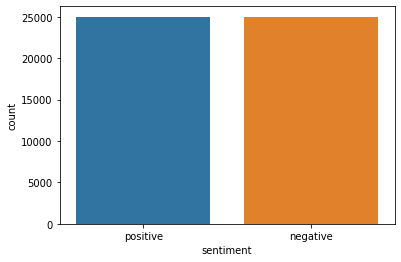

In [7]:
import seaborn as sns
ax=sns.countplot(x="sentiment", data=train)

=> La dataset est bien équilibrée.


Afficher le 4ème review, que remarquez-vous ?

In [8]:
train['review'].iloc[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

=> Plusieurs caractères inutules.


**Prétraitement de données**

In [9]:
def preprocess_text(sen):
 # Removing html tags
 sentence = remove_tags(sen)
 # Remove punctuations and numbers
 sentence = re.sub('[^a-zA-Z]', ' ', sentence)
 # Single character removal
 sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
 # Removing multiple spaces
 sentence = re.sub(r'\s+', ' ', sentence)
 return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
 return TAG_RE.sub('', text)

Prétraitez les reviews et stockez-les dans une nouvelle liste comme indiqué ci-dessous

In [10]:
X = []
sentences = list(train['review'])
for sen in sentences:
 X.append(preprocess_text(sen))

Réafficher le 4ème review

In [11]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

Nous devons convertir nos étiquettes en chiffres. Puisque nous n'avons que deux étiquettes dans la sortie, à savoir "positive" et "négative". Nous pouvons simplement les convertir en nombres entiers en remplaçant "positif" par le chiffre 1 et négatif par le chiffre 0 comme indiqué ci-dessous

In [12]:
y = train['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Diviser le dataset en training et test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)

**La couche de l’embedding**

Dans un premier temps, nous allons utiliser la classe Tokenizer du module **keras.preprocessing.text** pour créer un dictionnaire word-to-index. Dans le dictionnaire word-to-index, chaque mot du corpus est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé. Exécutez le script suivant

In [14]:
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train contient 40000 listes correspondant aux phrases où chacune contient des entiers.
La taille de chaque liste est différente car les phrases possèdent des tailles différentes.
Le script ci-dessous trouve la taille du vocabulaire, puis effectue un remplissage sur
l'ensemble d'entraînement et de test.

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 
maxlen = 100 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) 
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
X_train

array([[   4,    1,  296, ...,  198,  345, 3812],
       [   1,  412,  100, ...,   82,   99,    6],
       [ 128, 1307,  108, ...,    0,    0,    0],
       ...,
       [ 778,    8,   24, ...,    0,    0,    0],
       [   8,  347,   10, ...,    0,    0,    0],
       [ 274,  100,  121, ...,   67,   69, 1946]], dtype=int32)

Les listes ont la même longueur, c'est-à-dire 100. De plus, la variable vocabulary_size contient maintenant une valeur 92547, ce qui signifie que le corpus contient 92547 mots uniques. 
Nous utiliserons GloVe pour créer notre matrice de features. Dans le script suivant, nous chargeons GloVe et créons un dictionnaire qui contiendra des mots en tant que clés et leur liste d’embeddings correspondante en tant que valeurs.


1. **GLOVE**

In [17]:
from numpy import array 
from numpy import asarray 
from numpy import zeros 
def embeddings(path):
    embeddings_dictionary = dict() 
    embeddings_file = open(path) 
    for line in embeddings_file:
        records = line.split()
        word = records[0] 
        vector_dimensions = asarray(records[1:],dtype='float32') 
        embeddings_dictionary[word] = vector_dimensions
    embeddings_file.close()
    return embeddings_dictionary

In [18]:
#import glove
embeddings_dictionary=embeddings("/kaggle/input/glove6b100dtxt/glove.6B.100d.txt")

Enfin, nous allons créer une matrice d’embeddings où chaque numéro de ligne correspondra à l'index du mot dans le corpus. La matrice aura 100 colonnes où chaque colonne contiendra les embeddings GloVe pour les mots de notre corpus.

In [19]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
     embedding_vector = embeddings_dictionary.get(word)
     if embedding_vector is not None:
         embedding_matrix[index] = embedding_vector

**Classification avec un simple réseau de neurones**

In [20]:
def simple_model(X_train,y_train):
    #Select keras model type”: sequential
    model=Sequential()
    #“Choose the type of layer”: Embedding
    model.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False))
    #“Choose the type of layer”: Flatten
    model.add(Flatten())
    #“Choose the type of layer”: Dense + sigmoid
    model.add(Dense(1,activation='sigmoid'))
    #compile
    model.compile("adam",loss='binary_crossentropy',metrics=["acc"])
    #fit
    history = model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model, history

In [21]:
model, history=simple_model(X_train,y_train)

2022-05-05 11:26:35.235981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 11:26:35.347718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 11:26:35.348555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 11:26:35.349752: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/6
250/250 [==============================] - 2s 3ms/step - loss: 0.6071 - acc: 0.6688 - val_loss: 0.5690 - val_acc: 0.7076
Epoch 2/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4959 - acc: 0.7619 - val_loss: 0.5289 - val_acc: 0.7356
Epoch 3/6
250/250 [==============================] - 0s 2ms/step - loss: 0.4609 - acc: 0.7833 - val_loss: 0.5273 - val_acc: 0.7361
Epoch 4/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4378 - acc: 0.7982 - val_loss: 0.5197 - val_acc: 0.7461
Epoch 5/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4275 - acc: 0.8029 - val_loss: 0.5376 - val_acc: 0.7389
Epoch 6/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4064 - acc: 0.8180 - val_loss: 0.5334 - val_acc: 0.7455


In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 0s 2ms/step - loss: 0.5337 - acc: 0.7421
Test Score: 0.5336893200874329
Test Accuracy: 0.7421000003814697


In [23]:
import matplotlib.pyplot as plt
def plothist(history):
    plt.plot(history.history['acc']) 
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left') 
    plt.show() 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left') 
    plt.show()

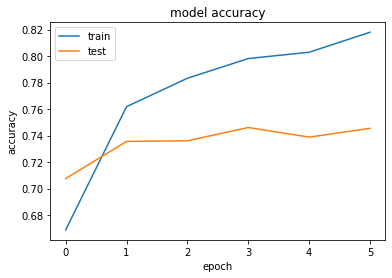

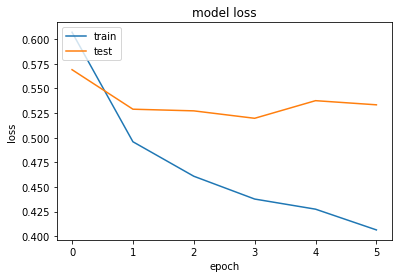

In [25]:
plothist(history)


**Classification avec un réseau de neurones convolutionnel**

In [26]:
def model_cnn(X_train,y_train):
    model_cnn=Sequential()
    model_cnn.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen))
    model_cnn.add(Conv1D(128,5,activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(1,activation='sigmoid'))
    model_cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_cnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_cnn,history

In [27]:
model_cnn,history=model_cnn(X_train,y_train)


Epoch 1/6


2022-05-05 11:27:11.884555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 8s 7ms/step - loss: 0.4776 - acc: 0.7694 - val_loss: 0.3582 - val_acc: 0.8456
Epoch 2/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3132 - acc: 0.8684 - val_loss: 0.3442 - val_acc: 0.8504
Epoch 3/6
250/250 [==============================] - 2s 6ms/step - loss: 0.2470 - acc: 0.8998 - val_loss: 0.3463 - val_acc: 0.8506
Epoch 4/6
250/250 [==============================] - 2s 6ms/step - loss: 0.1913 - acc: 0.9308 - val_loss: 0.3133 - val_acc: 0.8694
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.1434 - acc: 0.9554 - val_loss: 0.3210 - val_acc: 0.8679
Epoch 6/6
250/250 [==============================] - 2s 6ms/step - loss: 0.1052 - acc: 0.9738 - val_loss: 0.3330 - val_acc: 0.8704


In [28]:
score = model_cnn.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.3166 - acc: 0.8695
Test Score: 0.31660985946655273
Test Accuracy: 0.8694999814033508


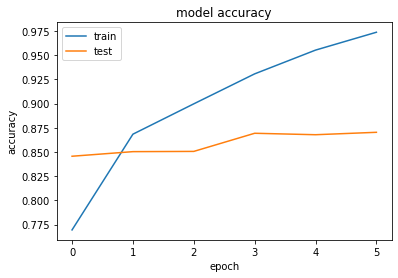

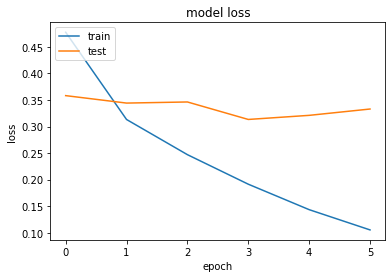

In [29]:
plothist(history)


**Classification avec un réseau de neurones récurrent (LSTM)**

In [30]:
def model_LSTM(X_train,y_train,l,embedding_matrix):
    model_lstm=Sequential()
    model_lstm.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen))
    model_lstm.add(LSTM(128))
    model_lstm.add(Dense(1,activation='sigmoid'))
    model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_lstm.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_lstm,history

In [31]:
model_lstm,history=model_LSTM(X_train,y_train,100,embedding_matrix)

Epoch 1/6
250/250 [==============================] - 5s 13ms/step - loss: 0.4921 - acc: 0.7552 - val_loss: 0.3553 - val_acc: 0.8445
Epoch 2/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3266 - acc: 0.8602 - val_loss: 0.3232 - val_acc: 0.8620
Epoch 3/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2847 - acc: 0.8815 - val_loss: 0.3147 - val_acc: 0.8660
Epoch 4/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2523 - acc: 0.8977 - val_loss: 0.3560 - val_acc: 0.8620
Epoch 5/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2303 - acc: 0.9085 - val_loss: 0.3323 - val_acc: 0.8669
Epoch 6/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2067 - acc: 0.9195 - val_loss: 0.3285 - val_acc: 0.8622


In [32]:
score = model_lstm.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3120 - acc: 0.8669
Test Score: 0.3119538128376007
Test Accuracy: 0.8669000267982483


In [33]:
predict_x=model_lstm.predict(X_test[7:8]) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[0]


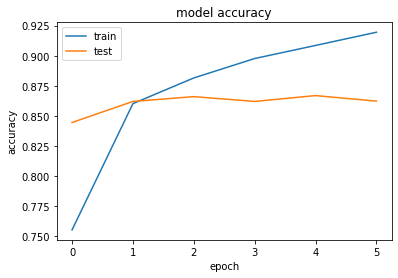

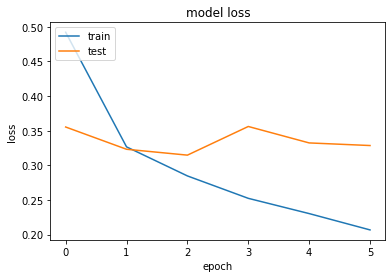

In [34]:
plothist(history)


=> RNN > CNN > Simple model

**Classification avec un réseau de neurones récurrent (GRU)**


In [39]:
from keras.layers import GRU
def model_GRU(X_train,y_train,l,embedding_matrix):
    model_gru=Sequential()
    model_gru.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen))
    model_gru.add(GRU(128))
    model_gru.add(Dense(1,activation='sigmoid'))
    model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_gru.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_gru,history

In [40]:
model_gru_glove,hist =model_GRU(X_train,y_train,100,embedding_matrix)


Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.4719 - acc: 0.7553 - val_loss: 0.3449 - val_acc: 0.8439
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3006 - acc: 0.8735 - val_loss: 0.3100 - val_acc: 0.8661
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2575 - acc: 0.8961 - val_loss: 0.3226 - val_acc: 0.8670
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2276 - acc: 0.9096 - val_loss: 0.3384 - val_acc: 0.8690
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1991 - acc: 0.9233 - val_loss: 0.3367 - val_acc: 0.8631
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1748 - acc: 0.9362 - val_loss: 0.3823 - val_acc: 0.8630


In [41]:
score = model_gru_glove.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3543 - acc: 0.8681
Test Score: 0.3542807400226593
Test Accuracy: 0.8680999875068665


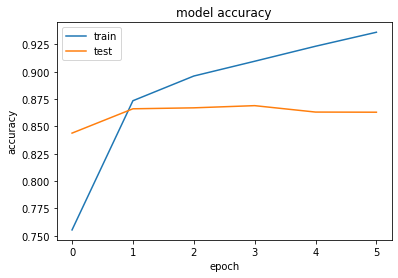

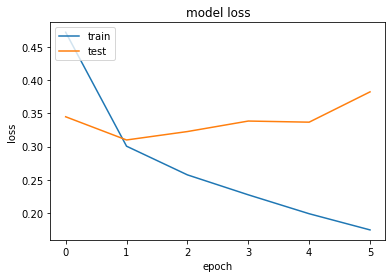

In [42]:
plothist(hist)


**Classification avec RNN +CNN**

In [47]:
from keras.layers import MaxPooling1D
def model_RNNCNN(X_train,y_train,l,embedding_matrix):
    model_rnncnn = Sequential()
    model_rnncnn.add((Embedding(vocab_size,l, weights=[embedding_matrix],input_length=maxlen)))
    model_rnncnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model_rnncnn.add(MaxPooling1D(pool_size=2))
    model_rnncnn.add(LSTM(128))
    model_rnncnn.add(Dense(1, activation='sigmoid'))
    model_rnncnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model_rnncnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnncnn,history

In [48]:
model_rnncnn_glove,history=model_RNNCNN(X_train,y_train,100,embedding_matrix)


Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.4901 - accuracy: 0.7487 - val_loss: 0.3777 - val_accuracy: 0.8317
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3169 - accuracy: 0.8654 - val_loss: 0.3208 - val_accuracy: 0.8645
Epoch 3/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2633 - accuracy: 0.8943 - val_loss: 0.3381 - val_accuracy: 0.8601
Epoch 4/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2252 - accuracy: 0.9103 - val_loss: 0.3304 - val_accuracy: 0.8681
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1861 - accuracy: 0.9293 - val_loss: 0.3554 - val_accuracy: 0.8604
Epoch 6/6
250/250 [==============================] - 3s 10ms/step - loss: 0.1431 - accuracy: 0.9479 - val_loss: 0.4069 - val_accuracy: 0.8586


In [49]:
score = model_rnncnn_glove.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3850 - accuracy: 0.8643
Test Score: 0.3849644660949707
Test Accuracy: 0.864300012588501


2. **Word2Vec**

In [50]:
word2vec=embeddings("../input/original-embeddings/GoogleNews-vectors-negative300(first500000).txt")

In [51]:
embedding_matrix1 = zeros((vocab_size, 300)) 
for word, index in tokenizer.word_index.items(): 
    embedding_vector = word2vec.get(word) 
    if embedding_vector is not None: 
        embedding_matrix1[index] = embedding_vector

In [52]:
embedding_matrix1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
model_rnncnn_wv,hist=model_RNNCNN(X_train,y_train,300,embedding_matrix1)

Epoch 1/6
250/250 [==============================] - 6s 18ms/step - loss: 0.3994 - accuracy: 0.8088 - val_loss: 0.3462 - val_accuracy: 0.8599
Epoch 2/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2633 - accuracy: 0.8934 - val_loss: 0.3040 - val_accuracy: 0.8721
Epoch 3/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2084 - accuracy: 0.9205 - val_loss: 0.3136 - val_accuracy: 0.8721
Epoch 4/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1309 - accuracy: 0.9542 - val_loss: 0.3694 - val_accuracy: 0.8585
Epoch 5/6
250/250 [==============================] - 4s 17ms/step - loss: 0.0725 - accuracy: 0.9770 - val_loss: 0.4561 - val_accuracy: 0.8465
Epoch 6/6
250/250 [==============================] - 4s 17ms/step - loss: 0.0399 - accuracy: 0.9883 - val_loss: 0.5094 - val_accuracy: 0.8645


In [54]:
score = model_rnncnn_wv.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4895 - accuracy: 0.8638
Test Score: 0.4895097613334656
Test Accuracy: 0.8637999892234802


**Classification avec un réseau de neurones récurrent (LSTM)**


In [55]:
model2,hist=model_LSTM(X_train,y_train,300,embedding_matrix1)

Epoch 1/6
250/250 [==============================] - 6s 19ms/step - loss: 0.4244 - acc: 0.8029 - val_loss: 0.3678 - val_acc: 0.8429
Epoch 2/6
250/250 [==============================] - 5s 19ms/step - loss: 0.3040 - acc: 0.8752 - val_loss: 0.3292 - val_acc: 0.8558
Epoch 3/6
250/250 [==============================] - 4s 18ms/step - loss: 0.2602 - acc: 0.8947 - val_loss: 0.3582 - val_acc: 0.8466
Epoch 4/6
250/250 [==============================] - 5s 18ms/step - loss: 0.2274 - acc: 0.9117 - val_loss: 0.4056 - val_acc: 0.8435
Epoch 5/6
250/250 [==============================] - 4s 18ms/step - loss: 0.1959 - acc: 0.9249 - val_loss: 0.4115 - val_acc: 0.8533
Epoch 6/6
250/250 [==============================] - 5s 18ms/step - loss: 0.1581 - acc: 0.9406 - val_loss: 0.4077 - val_acc: 0.8535


In [56]:
score = model2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.3913 - acc: 0.8555
Test Score: 0.391276091337204
Test Accuracy: 0.8554999828338623


**Classification avec un réseau de neurones récurrent (GRU)**


In [57]:
model3,his=model_GRU(X_train,y_train,300,embedding_matrix1)

Epoch 1/6
250/250 [==============================] - 6s 18ms/step - loss: 0.4288 - acc: 0.7941 - val_loss: 0.3352 - val_acc: 0.8569
Epoch 2/6
250/250 [==============================] - 4s 18ms/step - loss: 0.2899 - acc: 0.8817 - val_loss: 0.3192 - val_acc: 0.8643
Epoch 3/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2358 - acc: 0.9087 - val_loss: 0.3346 - val_acc: 0.8641
Epoch 4/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1921 - acc: 0.9283 - val_loss: 0.3499 - val_acc: 0.8590
Epoch 5/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1508 - acc: 0.9457 - val_loss: 0.3795 - val_acc: 0.8541
Epoch 6/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1176 - acc: 0.9583 - val_loss: 0.4751 - val_acc: 0.8456


In [58]:
score = model3.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4441 - acc: 0.8483
Test Score: 0.44412359595298767
Test Accuracy: 0.8482999801635742


3. **Fasttext**

In [61]:
from tqdm import tqdm

import os, re, csv, math, codecs

In [63]:
embeddings_index = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('%s word vectors' % len(embeddings_index))

111052it [00:14, 7912.43it/s]

111052 word vectors


In [64]:
embedding_matrix2 = zeros((vocab_size, 100)) 
for word, index in tokenizer.word_index.items(): 
    embeddings_index = embeddings_dictionary.get(word) 
    if embeddings_index is not None: 
        embedding_matrix2[index] = embeddings_index

In [65]:
embedding_matrix2


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

**Classification avec RNN +CNN**

In [66]:
model1FT,hist=model_RNNCNN(X_train,y_train,100,embedding_matrix2)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.4950 - accuracy: 0.7458 - val_loss: 0.3585 - val_accuracy: 0.8451
Epoch 2/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3373 - accuracy: 0.8545 - val_loss: 0.3213 - val_accuracy: 0.8643
Epoch 3/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2700 - accuracy: 0.8896 - val_loss: 0.3191 - val_accuracy: 0.8593
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2327 - accuracy: 0.9070 - val_loss: 0.3239 - val_accuracy: 0.8624
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.1921 - accuracy: 0.9270 - val_loss: 0.3729 - val_accuracy: 0.8629
Epoch 6/6
250/250 [==============================] - 3s 10ms/step - loss: 0.1550 - accuracy: 0.9416 - val_loss: 0.4168 - val_accuracy: 0.8400


In [67]:
score = model1FT.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3890 - accuracy: 0.8508
Test Score: 0.38902586698532104
Test Accuracy: 0.8507999777793884


**Classification avec un réseau de neurones récurrent LSTM**

In [69]:
model2FT,hist=model_LSTM(X_train,y_train,100,embedding_matrix2)

Epoch 1/6
250/250 [==============================] - 63s 14ms/step - loss: 0.5046 - acc: 0.7458 - val_loss: 0.4219 - val_acc: 0.8099
Epoch 2/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3345 - acc: 0.8570 - val_loss: 0.3330 - val_acc: 0.8595
Epoch 3/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2858 - acc: 0.8821 - val_loss: 0.3549 - val_acc: 0.8461
Epoch 4/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2531 - acc: 0.8990 - val_loss: 0.3272 - val_acc: 0.8645
Epoch 5/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2262 - acc: 0.9107 - val_loss: 0.3275 - val_acc: 0.8608
Epoch 6/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2040 - acc: 0.9208 - val_loss: 0.3585 - val_acc: 0.8597


In [71]:
predict_x=model2FT.predict(X_test[7:8]) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[0]


In [72]:
score = model2FT.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.3438 - acc: 0.8645
Test Score: 0.3438270390033722
Test Accuracy: 0.8644999861717224


**Classification avec un réseau de neurones récurrent (GRU)**


In [73]:
model3FT,his=model_GRU(X_train,y_train,100,embedding_matrix2)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.5125 - acc: 0.7241 - val_loss: 0.3409 - val_acc: 0.8545
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3046 - acc: 0.8705 - val_loss: 0.3065 - val_acc: 0.8676
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2575 - acc: 0.8959 - val_loss: 0.3184 - val_acc: 0.8686
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2240 - acc: 0.9119 - val_loss: 0.3258 - val_acc: 0.8729
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1954 - acc: 0.9246 - val_loss: 0.3470 - val_acc: 0.8616
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1639 - acc: 0.9390 - val_loss: 0.3619 - val_acc: 0.8609


In [74]:
score = model3FT.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3455 - acc: 0.8606
Test Score: 0.34550005197525024
Test Accuracy: 0.8605999946594238


4. **TFIDF**

In [75]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,
test_size=0.20, random_state=42)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer( use_idf=True, max_features=3000)
X_train_transformed = vectorizer.fit_transform(X_train1).toarray()
X_test_transformed = vectorizer.transform(X_test1).toarray()

In [77]:
X_train_transformed 


array([[0.        , 0.07323706, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [78]:
X_train_transformed1=X_train_transformed.reshape(X_train_transformed.shape[0],X_train_transformed.shape[1],1)
X_test_transformed1=X_test_transformed.reshape(X_test_transformed.shape[0],X_test_transformed.shape[1],1)

**Classification avec RNN+CNN**


In [80]:
def model_RNNCNN_TFIDF(X_train,y_train):
    modelx = Sequential()
    modelx.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    modelx.add(MaxPooling1D(pool_size=2))
    modelx.add(LSTM(128))
    modelx.add(Dense(1, activation='sigmoid'))
    modelx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=modelx.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return modelx,history

In [81]:
model1TFIDF,hist =model_RNNCNN_TFIDF(X_train_transformed1,y_train1)


Epoch 1/6
250/250 [==============================] - 33s 127ms/step - loss: 0.6839 - accuracy: 0.5485 - val_loss: 0.6721 - val_accuracy: 0.5809
Epoch 2/6
250/250 [==============================] - 31s 123ms/step - loss: 0.6734 - accuracy: 0.5804 - val_loss: 0.6732 - val_accuracy: 0.5794
Epoch 3/6
250/250 [==============================] - 31s 123ms/step - loss: 0.6710 - accuracy: 0.5854 - val_loss: 0.6678 - val_accuracy: 0.5947
Epoch 4/6
250/250 [==============================] - 31s 123ms/step - loss: 0.6673 - accuracy: 0.5914 - val_loss: 0.6677 - val_accuracy: 0.5894
Epoch 5/6
250/250 [==============================] - 31s 123ms/step - loss: 0.6651 - accuracy: 0.5929 - val_loss: 0.6662 - val_accuracy: 0.5882
Epoch 6/6
250/250 [==============================] - 31s 123ms/step - loss: 0.6640 - accuracy: 0.5924 - val_loss: 0.6574 - val_accuracy: 0.6080


In [82]:
score = model1TFIDF.evaluate(X_test_transformed1, y_test1, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 8s 26ms/step - loss: 0.6593 - accuracy: 0.6018
Test Score: 0.6592622399330139
Test Accuracy: 0.6018000245094299
